<a href="https://colab.research.google.com/github/hcc7402/Phys503-Work-Campos/blob/week7/homework_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 07: Markov Chains

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd

# github save check

## <span style="color:Orange">Problem 1</span>

We showed in class that a Markov chain can have long-range dependencies,

$$ \Large
P(X_n\mid X_{n-k}) \ne P(X_n) \; ,
$$

and commented that dependent random variables are usually, but not necessarily, correlated:

$$ \Large
\rho \equiv \frac{\langle (X_n - \mu) (X_{n-k} - \mu)\rangle}{\sigma^2} \ne 0 \; ,
$$

where $\mu$ and $\sigma$ are the chain's long-term mean and standard deviation, respectively.

However, it is possible to define (fairly artificial) distributions with dependent random variables that are uncorrelated.  For example:
 - $x_1$ is uniformly distributed in $[-1,+1]$.
 - $x_2 = |x_1|$.

Implement the function below to generate a dataset with these two features. Hints:
 - Use `uniform()` to generate values of $x_1$.
 - Use `np.corrcoef()` to calculate the correlation coefficient $\rho$.

In [3]:
def generate(n, seed):
    """Generate a dataset with two dependent but uncorrelated features.

    Parameters
    ----------
    n : int
        Number of samples to generate.
    seed : int
        Seed to use for reproducible random numbers.

    Returns
    -------
    tuple
        Tuple (X, rho) of generated data X with shape (n, 2) and the
        correlation coefficient rho of the generated data.
    """

    # YOUR CODE HERE

    gen = np.random.RandomState(seed=seed)    # generate random seed
    x1 = gen.uniform(low=-1, high=+1, size=n)   # using seed, generate random dataset
    x2 = np.abs(x1)   # take absolute vlaue of x1 dataset

    rho = np.corrcoef(x1, x2)[0, 1]   # calculate rho
    X = np.array([x1, x2]).T    # create array from x1 and x2

    return X, rho

    raise NotImplementedError()

In [4]:
# A correct solution should pass these tests.
X, _ = generate(n=3, seed=1)
assert np.all(np.round(X, 3) == [[-0.166,  0.166], [ 0.441,  0.441], [-1.000,  1.000]])
X, _ = generate(n=3, seed=2)
assert np.all(np.round(X, 3) == [[-0.128,  0.128], [-0.948,  0.948], [ 0.099,  0.099]])
_, rho = generate(n=10000, seed=3)
assert np.abs(rho) < 0.002

You have now demonstrated that $\rho \simeq 0$, and a plot of this dataset should convince you that $x_1$ and $x_2$ are (highly) dependent:

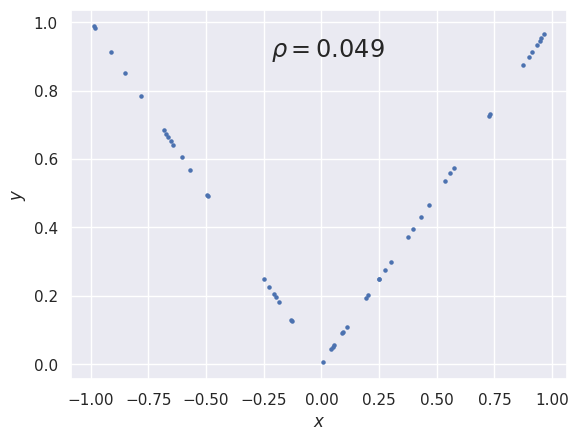

In [5]:
X, rho = generate(n=50, seed=4)
plt.scatter(X[:, 0], X[:, 1], s=5)
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.text(-0.22, 0.9, '$\\rho = {:.3f}$'.format(rho), fontsize='x-large');

## <span style="color:Orange">Problem 2</span>

In this problem, you will implement a Metropolis update rule to sample a Markov chain for the un-normalized probability density:

$$ \Large
P(x, y) \propto \frac{1}{2} \exp\left[-\frac{(x/s)^2 + (y s)^2}{2}\right] +
\frac{1}{2} \exp\left[-\frac{(x s)^2 + (y/s)^2}{2}\right]
$$

with hyperparameter $s > 0$.

In [6]:
def P(x,y,s):
    return 0.5 * (np.exp(-0.5 * ((x / s) ** 2 + (y * s) ** 2)) + np.exp(-0.5 * ((x * s) ** 2 + (y / s) ** 2)))

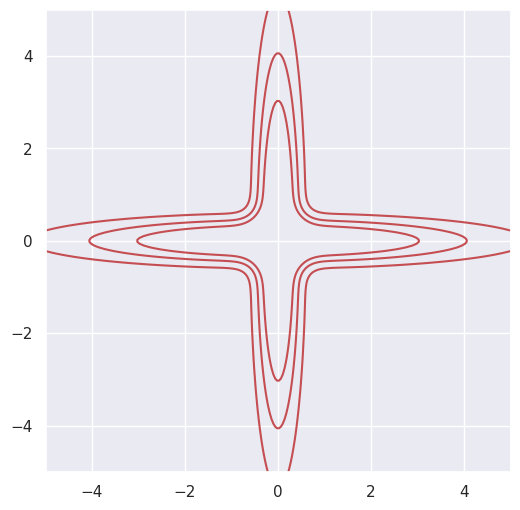

In [7]:
def plot_P(s=3, lim=5):
    fig = plt.figure(figsize=(6, 6))
    xy = np.linspace(-lim, +lim, 250)
    Pxy = P(xy, xy[:, np.newaxis], s)
    plt.contour(xy, xy, Pxy, [0.1, 0.2, 0.3], colors='r')

plot_P()

Implement the function below to perform a Metropolis update starting from $(x,y)$ and using a Gaussian proposal distribution $Q(x,y)$ centered at $(0,0)$ with standard deviation $\sigma$ along both coordinates. Use the "random walk" mode for your proposed updates.  (Recall that Metropolis updates are a special case of Metropolis-Hastings updates where the ratio of $Q$ factors cancels in the Hastings ratio.)

In [18]:
def metropolis_update(x, y, s, gen, sigma=1):
    """Perform a single Metropolis update.

    Parameters
    ----------
    x : float
        Value of x from the previous step.
    y : float
        Value of y from the previous step.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.
    sigma : float
        Standard deviation of the Gaussian proposal distribution Q(x,y).

    Returns
    -------
    tuple
        Tuple (x,y) of the position after the update.

    """

    # YOUR CODE HERE

    x_new = x + gen.normal(scale=sigma)   # updated x value
    y_new = y + gen.normal(scale=sigma)   # updated y value

    P_new = P(x_new, y_new, s)    # P calc with updated values
    P_old = P(x, y, s)    # P calc with old values

    alpha = min(1, P_new / P_old)   # acceptance probability

    if gen.uniform() < alpha:   # accept the new state
        return x_new, y_new
    else:   # reject the new state
        return x, y

    raise NotImplementedError()

In [19]:
# A correct solution should pass these tests.
s, n = 3, 1000
gen = np.random.RandomState(seed=123)
# Generate steps from (0, 0) with sigma=1
xy = np.array([metropolis_update(0, 0, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [0, 0], axis=1))
assert np.allclose(nrepeat / n, 0.69967, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0, 0], atol=0.1, rtol=0.1)
# Generate steps from (5, 0) with sigma=1
xy = np.array([metropolis_update(5, 0, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [5, 0], axis=1))
assert np.allclose(nrepeat / n, 0.70136, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [4.893, 0], atol=0.1, rtol=0.1)
# Generate steps from (1, -1) with sigma=1
xy = np.array([metropolis_update(1, -1, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [1, -1], axis=1))
assert np.allclose(nrepeat / n, 0.26665, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0.822, -0.822], atol=0.1, rtol=0.1)
# Generate steps from (1, -1) with sigma=2
xy = np.array([metropolis_update(1, -1, s, gen, sigma=2) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [1, -1], axis=1))
assert np.allclose(nrepeat / n, 0.43847, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0.781, -0.781], atol=0.1, rtol=0.1)

Test your solution with the following visualization:

In [20]:
def plot_chain(update_rule, x0=0, y0=0, s=3, n_updates=200, lim=5, seed=123, **kwargs):
    gen = np.random.RandomState(seed=seed)
    path = [(x0, y0)]
    for i in range(n_updates):
        path.append(update_rule(*path[-1], s, gen, **kwargs))
    plot_P(s, lim)
    x, y = np.array(path).T
    plt.scatter(x, y, s=10, c='k')
    plt.plot(x, y, 'k-', lw=0.5, alpha=0.3)
    plt.xlim(-lim, +lim)
    plt.ylim(-lim, +lim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

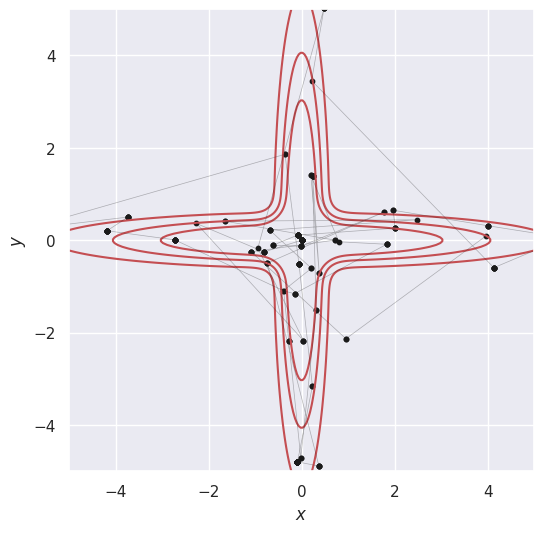

In [21]:
plot_chain(metropolis_update, sigma=2.0)

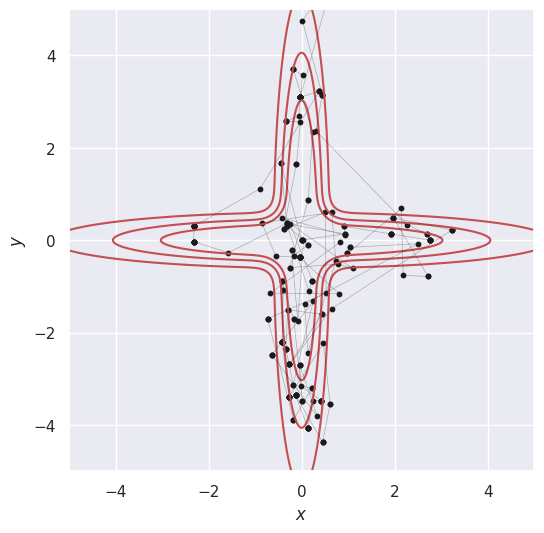

In [22]:
plot_chain(metropolis_update, sigma=1.0)

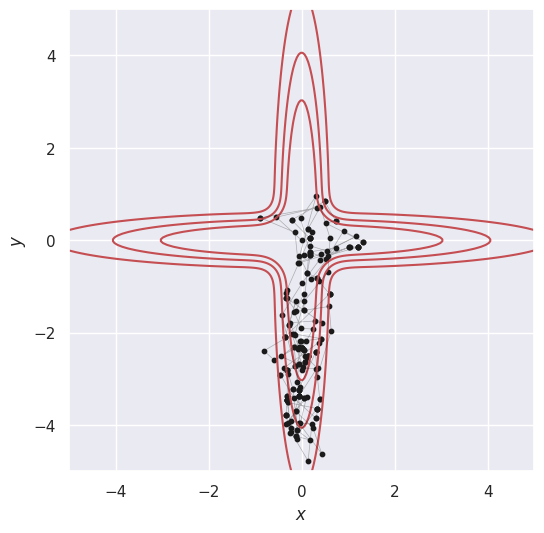

In [23]:
plot_chain(metropolis_update, sigma=0.5)

## <span style="color:Orange">Problem 3</span>

In this problem you will implement a Gibbs update rule for the same probability density.

Implement the function below to sample from the conditional distribution $P(x\mid y)$. Hint: each sample can be drawn from a single Gaussian with $\sigma = s$ or $\sigma = 1/s$ as long as you weight the contributions from each Gaussian correctly given $y$.

In [33]:
def sample_conditional(y, s, gen):
    """Sample from the conditional distribution P(x | y).

    Parameters
    ----------
    y : float
        Fixed value of y to use.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.

    Returns
    -------
    float
        Random value of x sampled from P(x | y).
    """

    # YOUR CODE HERE
    P_1 = 0.5 * np.exp(-0.5 * ((0 / s) ** 2 + (y * s) ** 2))    # first part of P
    P_2 = 0.5 * np.exp(-0.5 * ((0 * s) ** 2 + (y / s) ** 2))    # second part of P
    P = P_1 + P_2   # total P

    prob_P_1 = P_1 / P    # P_1 prob sample

    if gen.uniform() < prob_P_1:
        return gen.normal(scale=s)
    else:
        return gen.normal(scale=1/s)

    raise NotImplementedError()

In [34]:
# A correct solution should pass these tests.
s, n = 3, 10000
gen = np.random.RandomState(seed=123)
# With y=+/-4, the distribution of x should be narrow.
x = [sample_conditional(+4, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 50, 95)), [-0.549, 0, +0.549], atol=0.1, rtol=0.1)
x = [sample_conditional(-4, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 50, 95)), [-0.549, 0, +0.549], atol=0.1, rtol=0.1)
# With y=0, the distribution of x should have a narrow core and a wide tail.
x = [sample_conditional(0, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 25, 50, 75, 95)), [-3.84, -0.50, 0, +0.50, +3.84], atol=0.1, rtol=0.1)

Implement the function below to perform a Gibbs update consisting of:
 - Sample $x_{n+1}$ from $P_X(x\mid y_n)$
 - Sample $y_{n+1}$ from $P_Y(y\mid x_{n+1})$

Note that you can use `sample_conditional()` for both steps by noticing that $P_Y(y\mid x)$ equals $P_X(x\mid y)$ when $x$ and $y$ are swapped.

In [ ]:
def gibbs_update(x, y, s, gen):
    """Perform a single Gibbs update.

    Parameters
    ----------
    x : float
        Value of x from the previous step.
    y : float
        Value of y from the previous step.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.

    Returns
    -------
    tuple
        Tuple (x,y) of the position after the update.
    """

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
s, n = 3, 10000
gen = np.random.RandomState(seed=123)
# Generate steps from (0,0).
xy = np.array([gibbs_update(0, 0, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-3.849, -0.502, 0, +0.502, +3.849], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-2.36, -0.297, 0, +0.297, +2.36], atol=0.1, rtol=0.1)
# Steps from (5,0) have the same distribution.
xy = np.array([gibbs_update(5, 0, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-3.849, -0.502, 0, +0.502, +3.849], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-2.36, -0.297, 0, +0.297, +2.36], atol=0.1, rtol=0.1)
# Steps from (0,-5) have a different distribution.
xy = np.array([gibbs_update(0, -5, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-0.548, -0.225, 0, +0.225, +0.548], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-3.42, -0.391, 0, +0.391, +3.42], atol=0.1, rtol=0.1)

Test your solution with the following visualization:

In [ ]:
plot_chain(gibbs_update)

## <span style="color:Orange">Problem 4</span>

If we define the potential energy for a "particle" as:

$$ \Large
U(x,y) \equiv -\log P(x,y)
$$

it has partial derivatives:

$$ \Large
\frac{\partial}{\partial x} U(x,y) = x\, \frac{E_1 / s^2 + E_2 s^2}{E_1 + E_2} \quad, \quad
\frac{\partial}{\partial y} U(x,y) = y\, \frac{E_1 s^2 + E_2 / s^2}{E_1 + E_2}
$$

with

$$ \Large
E_1(x,y) \equiv \frac{1}{2} \exp\left[-\frac{(x/s)^2 + (y s)^2}{2}\right] \quad, \quad
E_2(x,y) \equiv \frac{1}{2} \exp\left[-\frac{(x s)^2 + (y/s)^2}{2}\right] \; .
$$

A Hamiltonian MC simulates the trajectory of a particle using the equations of motion:

$$ \Large
x \rightarrow x + p_x \Delta t \quad, \quad
y \rightarrow y + p_y \Delta t \quad, \quad
p_x \rightarrow p_x - \frac{\partial}{\partial x} U(x,y) \Delta t \quad, \quad
p_y \rightarrow p_y - \frac{\partial}{\partial y} U(x,y) \Delta t \; ,
$$

where we have set all masses equal to 1 and the temperature $k_B T = 1$.

Implement the function below to perform a single $\Delta t$ step according to the equations above:

In [ ]:
def HMC_step(x, y, px, py, s, dt):
    """Perform a single HMC dt step.

    Parameters
    ----------
    x : float
        Current x position.
    y : float
        Current y position.
    px : float
        Current x momentum.
    py : float
        Current y momentum.
    s : float
        Value of the hyperparameter s.
    dt : float
        Step size to take.

    Returns
    -------
    tuple
        Tuple (x, y, px, py) with particle position and momentum after this step.
    """

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# A correct solution should pass these tests.
assert np.all(HMC_step(0., 0., 0., 0., 3, 1.) == np.array([0.,0.,0.,0.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 0.) == np.array([0.,0.,1.,1.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 1.) == np.array([1.,1.,1.,1.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 2.) == np.array([2.,2.,1.,1.]))
assert np.all(np.round(HMC_step(1., 1., -1., 1., 3, 1.), 3) == np.array([0.,2.,-5.556,-3.556]))
assert np.all(np.round(HMC_step(0., 1., -1., 1., 3, 1.), 3) == np.array([-1.,2.,-1.,0.786]))
assert np.all(np.round(HMC_step(1., 0., -1., 1., 3, 1.), 3) == np.array([0.,1.,-1.214,1.]))

In order to perform an HMC update, we first need to generate random values of the (nuisance) parameters $p_x$ and $p_y$, then we follow the resulting particle from its initial conditions through a fixed number of steps. The result of the update is wherever the particle ends up. Note that the only use of random numbers is to generate the particle's initial momentum.

In [ ]:
def HMC_update(x0, y0, s, gen, p_sigma, n_steps, dt):
    """Perform a single HMC update by following a single particle for a fixed time.

    Parameters
    ----------
    x0 : float
        Initial x position.
    y0 : float
        Initial y position.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.
    p_sigma : float
        Gaussian sigma for generating random initial (px,py) values.
    n_steps : int
        Number of particle steps to simulate.
    dt : float
        Size of each step.

    Returns
    -------
    array
        Array of shape (n_steps + 1, 4) with the particle position and momentum after each step.
    """
    px0, py0 = gen.normal(scale=p_sigma, size=2)
    path = [(x0, y0, px0, py0)]
    for i in range(n_steps):
        path.append(HMC_step(*path[-1], s, dt))
    return np.array(path)

Finally, use the following visualization to see the particle trajectories from different updates:

In [ ]:
def plot_HMC(x0=0, y0=0, s=3, p_sigma=1., n_steps=500, dt=0.01, n_updates=50, lim=5, seed=3, **kwargs):
    gen = np.random.RandomState(seed=seed)
    plot_P(s, lim)
    for i in range(n_updates):
        path = HMC_update(x0, y0, s, gen, p_sigma, n_steps, dt)
        x, y, px, py = np.array(path).T
        plt.scatter(x[-1], y[-1], s=25, c='k')
        plt.plot(x, y, 'b-', lw=1, alpha=0.3)
    plt.xlim(-lim, +lim)
    plt.ylim(-lim, +lim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

plot_HMC()

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025